## Practical 8bis: Working with Text (Part 2)

The basics of Text Mining and NLP

Part 2 of Practical 8 is *optional* and should only be attempted if Part
1 made sense to you.

1.  The first few tasks are about finding important vocabulary (think
    ‘keywords’ and ‘significant terms’) in documents so that you can
    start to think about what is *distinctive* about documents and
    groups of documents. **This is quite useful and relatively easier to
    understand than what comes next!**
2.  The second part is about fully-fledged NLP using Latent Direclecht
    Allocation (topic modelling) and Word2Vec (words embeddings for use
    in clustering or similarity work).

The later parts are largely complete and ready to run; however, that
*doesn’t* mean you should just skip over them and think you’ve grasped
what’s happening and it will be easy to apply in your own analyses. I
would *not* pay as much attention to LDA topic mining since I don’t
think it’s results are that good, but I’ve included it here as it’s
still commonly-used in the Digital Humanities and by Marketing folks.
Word2Vec is much more powerful and forms the basis of the kinds of
advances seen in ChatGPT and other LLMs.

> **🔗 Connections**
>
> Working with text is unquestionably *hard*. In fact, *conceptually*
> this is probaly the most challenging practical of the term! But data
> scientists are *always* dealing with text because so much of the data
> that we collect (even more so thanks to the web) is not only
> text-based (URLs are text!) but, increasingly, unstructured (social
> media posts, tags, etc.). So while getting to grips with text is a
> challenge, it also uniquely positions you with respect to the skills
> and knowledge that other graduates are offering to employers.

## 1. Preamble

Parts of this practical have been written using `nltk` and `gensim` —
both of which I have **removed** from the sds2025 image to keep the size
down and because relatively few students used any of this — but it would
be *relatively* easy to rework it to use `spacy`. From what I can see,
most programmers tend to use one *or* the other, and the switch wouldn’t
be hard, other than having to first load the requisite language models.
You can [read about the models](https://spacy.io/models/en), and note
that they are also [available in other
languages](https://spacy.io/usage/models) besides English.

## 2. Setup

> **Difficulty Level: Low**
>
> But this is only because this has been worked out for you. Starting
> from sctach in NLP is *hard* so people try to avoid it as much as
> possible.

### 2.1 Required Modules

> **Note**
>
> Notice that the number of modules and functions that we import is
> steadily increasing week-on-week, and that for text processing we tend
> to draw on quite a wide range of utilies! That said, the three most
> commonly used are: `sklearn` and `nltk`.

Standard libraries we’ve seen before.

In [1]:
import pandas as pd
import geopandas as gpd
import re
import matplotlib.pyplot as plt

# New, but fairly straightforward (for simple things)
from bs4 import BeautifulSoup

Vectorisers we will use from the ‘big beast’ of Python machine learning:
Sci-Kit Learn.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# We don't use this but I point out where you *could*
from sklearn.preprocessing import OneHotEncoder 

NLP-specific libraries that we will use for tokenisation, lemmatisation,
and frequency analysis.

In [3]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

try:
    from nltk.corpus import stopwords
except:
    ! python -c 'import nltk; nltk.download("stopwords"); nltk.download("punkt_tab"); nltk.download("averaged_perceptron_tagger_eng");'
    from nltk.corpus import stopwords

stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

Remaining libraries that we’ll use for processing and display text data.
Most of this relates to dealing with the various ways that text data
cleaning is *hard* because of the myriad formats it comes in.

In [4]:
import string
import unicodedata
from wordcloud import WordCloud, STOPWORDS

This next is just a small utility function that allows us to output
Markdown (like this cell) instead of plain text:

In [5]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('Result!', "Here's my output...")

### 2.2 Loading Data

> **🔗 Connections**
>
> Because I generally want each practical to stand on its own (unless
> I’m trying to make a *point*), I’ve not moved this to a separate
> Python file (e.g. `utils.py`, but in line with what we covered back in
> the lectures on [Functions and
> Packages](https://jreades.github.io/fsds/sessions/week3.html#lectures),
> this sort of thing is a good candidate for being split out to a
> separate file to simplify re-use.

Remember this function from last week? We use it to save downloading
files that we already have stored locally. But notice I’ve made some
small changes… what do these do to help the user?

In [6]:
from pathlib import Path
from requests import get
from functools import wraps

def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        if src.find('?') == -1:
            url = Path(src)
        else:
            url = Path(src[:src.find('?')])
        fn  = url.name  # Extract the filename
        dsn = Path(f"{dst}/{fn}") # Destination filename
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create any missing directories in dest(ination) path
    # -- os.path.join is the reverse of split (as you saw above)
    # but it doesn't work with lists... so I had to google how
    # to use the 'splat' operator! os.makedirs creates missing
    # directories in a path automatically.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

> **Tip**
>
> For very large *non*-geographic data sets, remember that you can
> `use_cols` (or `columns` depending on the file type) to specify a
> subset of columns to load.

Load the main data set:

In [7]:
# Load the data sets created in the previous practical
lux    = gpd.read_parquet(Path('data/clean/luxury.geoparquet'))
aff    = gpd.read_parquet(Path('data/clean/affordable.geoparquet'))
bluesp = gpd.read_parquet(Path('data/clean/bluespace.geoparquet'))

## 3. Illustrative Text Cleaning

Now we’re going to step through the *parts* of the process that we apply
to clean and transform text. We’ll do this individually before using a
function to apply them *all at once*. To keep things moving along, we’re
going to take a small sample from the data set.

In [8]:
pd.set_option("display.max_colwidth", 250)
sample = bluesp.description.sample(5, random_state=44)
sample

10390    Stunning & Spacious Air Conditioned 3 bedroom 3BR Apartment on the Ground floor with its own terrace in a prime Location Chelsea .<br /><br />The Perfect Place for a Lovely and comfortable Stay in the heart of Chelsea, just few minutes walk to Ri...
34253    his charming house boasts a prime location just a 5-minute stroll from iconic landmarks such as Big Ben and the London Eye, as well as being conveniently close to Waterloo station. You'll find bus stops and supermarkets nearby for added convenien...
49617    Key features:<br />Three double bedrooms<br />Two bathrooms<br />Close to Waterloo<br />Excellent transport links<br />Beautiful finish<br />Wood flooring throughout<br /><br />Full description:<br />An impressive 1115sqft (104sqm) contemporary t...
56882    Private double ensuite bedroom in a shared home. 8 min walk to Surbiton station (20 min direct to Waterloo), 3 min walk to River Thames, 20 min walk to Kingston town centre, easy bus or train to Wimbledon.<br /><br

### 3.1 Removing HTML

> **Difficulty level: Moderate**
>
> You’ll have seen that tehre are some things that are *not* text in the
> sample, most notably this stuff: `<br>` and `<br />`. That is raw
> HTML, the markup language for web pages. To go any further we will
> need to strip this out. Depending on what you needed to extract from a
> web page you *can* select different elements by name, class, or id,
> and do a whole bunch of other things, but here we’re just going to
> crudely strip the tags out.
>
> You’re also going to see a powerful new method: `apply`. Apply simply
> runs some function against every row or column in the data set
> depending on how it’s called. In this case, we use a `lambda` function
> (a function without a formal `def`inition) to create a ‘Beautiful
> Soup’ HTML parser and then strip the tags from each row.

*Hint*: you need to need to **get the text** out of the each returned
`<p>` and `<div>` element! I’d suggest also commenting this up since
there is a *lot* going on on some of these lines of code!

##### 3.1.0.1 Question

In [ ]:
cleaned = sample.apply(lambda x: BeautifulSoup(??, 'html.parser').??(" "))
cleaned

10390    Stunning & Spacious Air Conditioned 3 bedroom 3BR Apartment on the Ground floor with its own terrace in a prime Location Chelsea . The Perfect Place for a Lovely and comfortable Stay in the heart of Chelsea, just few minutes walk to River Thames ...
34253    his charming house boasts a prime location just a 5-minute stroll from iconic landmarks such as Big Ben and the London Eye, as well as being conveniently close to Waterloo station. You'll find bus stops and supermarkets nearby for added convenien...
49617    Key features: Three double bedrooms Two bathrooms Close to Waterloo Excellent transport links Beautiful finish Wood flooring throughout Full description: An impressive 1115sqft (104sqm) contemporary three double bedroom two bathroom first floor c...
56882    Private double ensuite bedroom in a shared home. 8 min walk to Surbiton station (20 min direct to Waterloo), 3 min walk to River Thames, 20 min walk to Kingston town centre, easy bus or train to Wimbledon. The home

### 3.2 Lower Case

> **Difficulty Level: Low.**

##### 3.2.0.1 Question

In [ ]:
lower = cleaned.??
lower

You should get something like the following:

10390    stunning & spacious air conditioned 3 bedroom 3br apartment on the ground floor with its own terrace in a prime location chelsea . the perfect place for a lovely and comfortable stay in the heart of chelsea, just few minutes walk to river thames ...
34253    his charming house boasts a prime location just a 5-minute stroll from iconic landmarks such as big ben and the london eye, as well as being conveniently close to waterloo station. you'll find bus stops and supermarkets nearby for added convenien...
49617    key features: three double bedrooms two bathrooms close to waterloo excellent transport links beautiful finish wood flooring throughout full description: an impressive 1115sqft (104sqm) contemporary three double bedroom two bathroom first floor c...
56882    private double ensuite bedroom in a shared home. 8 min walk to surbiton station (20 min direct to waterloo), 3 min walk to river thames, 20 min walk to kingston town centre, easy bus or train to wimbledon. the home

### 3.3 Stripping ‘Punctuation’

> **Difficulty level: Hard**
>
> This is because you need to understand: 1) why we’re *compiling* the
> regular expression and how to use character classes; and 2) how the
> NLTK tokenizer differs in its approach to the regex.

#### 3.3.1 Regular Expression Approach

We want to clear out punctuation using a regex that takes advantage of
the `[...]` (character class) syntax. The really tricky part is
remembering how to specify the ‘punctuation’ when some of that
punctuation has ‘special’ meanings in a regular expression context. For
instance, `.` means ‘any character’, while `[` and `]` mean ‘character
class’. So this is another *escaping* problem and it works the *same*
way it did when we were dealing with the Terminal…

*Hints*: some other factors…

1.  You will want to match more than one piece of punctuation at a time,
    so I’d suggest add a `+` to your pattern.
2.  You will need to look into *metacharacters* for creating a kind of
    ‘any of the characters *in this class*’ bag of possible matches.

##### 3.3.1.1 Question

In [ ]:
pat = re.compile(r'[???]+')
subbed = lower.apply(lambda x: pat.sub('',x))

Depending on how thorough you are, you should get something like this:

10390    stunning  spacious air conditioned 3 bedroom 3br apartment on the ground floor with its own terrace in a prime location chelsea  the perfect place for a lovely and comfortable stay in the heart of chelsea just few minutes walk to river thames and...
34253    his charming house boasts a prime location just a 5minute stroll from iconic landmarks such as big ben and the london eye as well as being conveniently close to waterloo station youll find bus stops and supermarkets nearby for added convenience i...
49617    key features: three double bedrooms two bathrooms close to waterloo excellent transport links beautiful finish wood flooring throughout full description: an impressive 1115sqft 104sqm contemporary three double bedroom two bathroom first floor con...
56882    private double ensuite bedroom in a shared home 8 min walk to surbiton station 20 min direct to waterloo 3 min walk to river thames 20 min walk to kingston town centre easy bus or train to wimbledon the home is sha

#### 3.3.2 Tokenizer

The other way to do this, which is probably *easier*, is to draw on the
tokenizers [already provided by
NLTK](https://www.nltk.org/api/nltk.tokenize.html). For our purposes
`word_tokenize` is probably fine, but depending on your needs there are
other options and you can also write your own.

In [15]:
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
tokens = lower.apply(word_tokenize)
tokens

[nltk_data] Downloading package punkt to /Users/jreades/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jreades/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

10390    [stunning, &, spacious, air, conditioned, 3, bedroom, 3br, apartment, on, the, ground, floor, with, its, own, terrace, in, a, prime, location, chelsea, ., the, perfect, place, for, a, lovely, and, comfortable, stay, in, the, heart, of, chelsea, ,...
34253    [his, charming, house, boasts, a, prime, location, just, a, 5-minute, stroll, from, iconic, landmarks, such, as, big, ben, and, the, london, eye, ,, as, well, as, being, conveniently, close, to, waterloo, station, ., you, 'll, find, bus, stops, a...
49617    [key, features, :, three, double, bedrooms, two, bathrooms, close, to, waterloo, excellent, transport, links, beautiful, finish, wood, flooring, throughout, full, description, :, an, impressive, 1115sqft, (, 104sqm, ), contemporary, three, double...
56882    [private, double, ensuite, bedroom, in, a, shared, home, ., 8, min, walk, to, surbiton, station, (, 20, min, direct, to, waterloo, ), ,, 3, min, walk, to, river, thames, ,, 20, min, walk, to, kingston, town, centre

> **Not Equivalent!**
>
> Notice that these aren’t giving you the same result!
>
> For our purposes it is easier in the subsequent stages to work with
> the `list` output from tokenize rather than the string output from
> `re.sub`, but if you needed to convert tokenise back to a string you
> could do it this way:
>
> ``` python
> tokens = lower.apply(word_tokenize).apply(lambda x: ' '.join(x))
> ```
>
> The other way around would be:
>
> ``` python
> lower.apply(lambda x: pat.sub('',x)).str.split(' ')
> ```

### 3.4 Stopword Removal

> **Difficulty Level: Moderate**
>
> You need to remember how list comprehensions work to use the
> `stopword_list`.

In [16]:
stopword_list = set(stopwords.words('english'))
print(stopword_list)

{'no', 'theirs', 'at', 'very', 'don', "you'll", 'it', 'ain', 'doesn', 'any', 'shan', "mustn't", 'before', 'that', 'only', 'was', 'had', 'into', 'hasn', "hasn't", 'again', "won't", "didn't", 'yourselves', 'their', 'yours', 'from', 'i', 'and', 'y', 'until', "should've", 'is', 'won', 'above', 'these', 'same', 'here', 'between', "it's", 'because', 'to', "that'll", 'off', 'am', 'when', 't', "isn't", 'mightn', 'haven', "mightn't", 'didn', "doesn't", 'wasn', 'his', 'she', 'more', 'below', 'with', 'why', 'all', 'each', 'm', 'then', 'did', 'can', 'ourselves', 'most', 'of', 'you', 'further', 'as', 'himself', 'yourself', 'where', 'does', 'once', 'few', 'but', 'against', 's', "hadn't", 'd', 'while', 'those', 'down', 'over', 'own', "shouldn't", "you've", 'other', 'such', 'an', "shan't", "weren't", 'our', 'if', 'isn', 'will', 'there', 'itself', 'wouldn', 'he', 'themselves', 'out', "haven't", 'doing', 'through', 'aren', 'll', 'myself', 'be', 'how', 'should', 'are', 'been', "you'd", 'ma', 'too', "aren

##### 3.4.0.1 Question

In [ ]:
passthru = []
for t in tokens[2:4]:
    passthru.append([x for x in t if ?? and len(x) > 1])

for p in passthru:
    as_markdown("Stopwords removed:", p)

### 3.5 Lemmatisation vs Stemming

> **Difficulty level: Low.**

In [18]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

In [19]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('monkeys'))
print(lemmatizer.lemmatize('cities'))
print(lemmatizer.lemmatize('complexity'))
print(lemmatizer.lemmatize('Reades'))

monkey
city
complexity
Reades

In [20]:
stemmer = SnowballStemmer(language='english')
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read

In [21]:
lemmatizer = WordNetLemmatizer()
stemmer    = SnowballStemmer(language='english')

# This would be better if we passed in a PoS (Part of Speech) tag as well,
# but processing text for parts of speech is *expensive* and for the purposes
# of this tutorial, not necessary.
lemmas  = passthru.apply(lambda x: [lemmatizer.lemmatize(t) for t in x])
stemmed = passthru.apply(lambda x: [stemmer.stem(t) for t in x])

as_markdown("Lemmatised", '\n\n>'.join(lemmas.str.join(' ').to_list()))
print("\n\n")
as_markdown("Stemmed", '\n\n>'.join(stemmed.str.join(' ').to_list()))

## 4. Applying Normalisation

The above approach is fairly hard going since you need to loop through
every list element applying these changes one at a time. Instead, we
could convert the column to a corpus (or use pandas `apply`) together
with a function imported from a library to do the work.

### 4.1 Downloading the Custom Module

In a Jupyter notebook, this code allows us to edit and reload the
library dynamically:

``` python
%load_ext autoreload
%autoreload 2
```

> **Difficulty level: Low.**

This custom module is not perfect, but it gets the job done… mostly and
has some additional features that you could play around with for a final
project (e.g. `detect_entities` and `detect_acronyms`).

In [22]:
try: 
    from textual import *
except:
    import urllib.request
    host  = 'https://orca.casa.ucl.ac.uk'
    turl  = f'{host}/~jreades/__textual__.py'
    tdirs = Path('textual')
    tpath = Path(tdirs,'__init__.py')

    if not tpath.exists():
        tdirs.mkdirs(parents=True, exist_ok=True)
        urllib.request.urlretrieve(turl, tpath)
    from textual import *

All NLTK libraries installed...

### 4.2 Importing the Custom Module

> **Difficulty Level: Low.**
>
> But only because you didn’t have to write the module! However, the
> questions could be hard…

In [23]:
normalised = sample.apply(normalise_document, remove_digits=True)
as_markdown('Normalised', '\n\n>'.join(normalised.to_list()))

``` python
help(normalise_document)
```

> **Stop!**
>
> Beyond this point, we are moving into Natural Language Processing. If
> you are already struggling with regular expressions, I would recommend
> *stopping here*. You can come back to revisit the NLP components and
> creation of word clouds later.

## 5. Process the Selected Listings

> **Difficulty level: Low, but you’ll need to be patient!**

Notice the use of `%%time` here – this will tell you how long each block
of code takes to complete. It’s a really useful technique for reminding
*yourself* and others of how long something might take to run. I find
that with NLP this is particularly important since you have to do a
*lot* of processing on each document in order to normalise it.

> **Tip**
>
> Notice how we can change the default parameters for
> `normalise_document` even when using `apply`, but that the syntax is
> different. So whereas we’d use
> `normalise_document(doc, remove_digits=True)` if calling the function
> directly, here it’s `.apply(normalise_document, remove_digits=True)`!

##### 5.0.0.1 Question

In [ ]:
%%time  
# I get about 2 seconds on a M2 Mac
bluesp['description_norm'] = bluesp.???.apply(???, remove_digits=True)

### 5.1 Select and Tokenise

> **Difficulty level: Low, except for the double list-comprehension.**

#### 5.1.1 Select and Extract Corpus

See useful tutorial
[here](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275).
Although we shouldn’t have any empty descriptions, by the time we’ve
finished normalising the textual data we may have *created* some empty
values and we need to ensure that we don’t accidentally pass a NaN to
the vectorisers and frequency distribution functions.

In [25]:
# This makes it easy to go back and re-run
# the analysis with other data subsets.
srcdf = bluesp 

> **Coding Tip**
>
> Notice how you only need to change the value of the variable here to
> try any of the different selections we did above? This is a simple
> kind of parameterisation somewhere between a function and hard-coding
> everything.

In [26]:
corpus = srcdf.description_norm.fillna(' ').values
print(corpus[0:3])

['well decorate sunny garden flat fulham park gardens close putney bridge tube .this comfortable double bedroom open plan flat sleep people . situated quiet residential street close shop restaurant kings road . close river thames bishops park tennis courts childre play area . broadband desk area . cleaning professional team adhere covid requirement sanitation .'
 'enjoy warm cosy modern apartment . river view gorgeous view city . walk barking station  easy transportation link city within minsmins . drive distance canary wharf district line   overground easy link northern line jubilee line .'
 'make memory unique familyfriendly place . near nice bridge minute away harrods london . cycling area  jungle park  river view playground available walkable distance . minute walk uxbridge underground station . minute walk shop mall . private parking bike . security service available . security deposit pound . refund hour checkout .']

#### 5.1.2 Tokenise

There are different forms of tokenisation and different algorithms will
expect differing inputs. Here are two:

In [27]:
sentences = [nltk.sent_tokenize(text) for text in corpus]
words     = [[nltk.tokenize.word_tokenize(sentence) 
                  for sentence in nltk.sent_tokenize(text)] 
                  for text in corpus]

Notice how this has turned every sentence into an array and each
document into an array of arrays:

In [28]:
print(f"Sentences 0: {sentences[0]}")
print()
print(f"Words 0: {words[0]}")

Sentences 0: ['well decorate sunny garden flat fulham park gardens close putney bridge tube .this comfortable double bedroom open plan flat sleep people .', 'situated quiet residential street close shop restaurant kings road .', 'close river thames bishops park tennis courts childre play area .', 'broadband desk area .', 'cleaning professional team adhere covid requirement sanitation .']

Words 0: [['well', 'decorate', 'sunny', 'garden', 'flat', 'fulham', 'park', 'gardens', 'close', 'putney', 'bridge', 'tube', '.this', 'comfortable', 'double', 'bedroom', 'open', 'plan', 'flat', 'sleep', 'people', '.'], ['situated', 'quiet', 'residential', 'street', 'close', 'shop', 'restaurant', 'kings', 'road', '.'], ['close', 'river', 'thames', 'bishops', 'park', 'tennis', 'courts', 'childre', 'play', 'area', '.'], ['broadband', 'desk', 'area', '.'], ['cleaning', 'professional', 'team', 'adhere', 'covid', 'requirement', 'sanitation', '.']]

## 6. Frequencies and Ngrams

> **Difficulty level: Moderate.**

One new thing you’ll see here is the `ngram`: ngrams are ‘simply’ pairs,
or triplets, or quadruplets of words. You may come across the terms
unigram (`ngram(1,1)`), bigram (`ngram(2,2)`), trigram (`ngram(3,3)`)…
typically, you will rarely find anything beyond trigrams, and these
present real issues for text2vec algorithms because the embedding for
`geographical`, `information`, and `systems` is *not* the same as for
`geographical information systetms`.

#### 6.0.1 Build Frequency Distribution

Build counts for ngram range 1..3:

In [29]:
fcounts = dict()

# Here we replace all full-stops... can you think why we might do this?
data = nltk.tokenize.word_tokenize(' '.join([text.replace('.','') for text in corpus]))

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one note this: https://stackoverflow.com/a/52193485/4041902
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

<FreqDist with 1838 samples and 13751 outcomes>
<FreqDist with 8020 samples and 13750 outcomes>
<FreqDist with 10515 samples and 13749 outcomes>

#### 6.0.2 Output Top-n Ngrams

And output the most common ones for each ngram range:

In [30]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))
    print()

           Ngram Size 1
walk                501
london              327
minute              282
river               276
station             275
view                194
apartment           193
thames              172
room                164
bedroom             162

                  Ngram Size 2
minute  walk               190
river   view                98
        thames              83
central london              74
canary  wharf               63
walk    river               46
        waterloo            42
thames  river               41
living  room                37
walk    distance            36

                           Ngram Size 3
walk    river    thames              37
station minute   walk                25
fully   equip    kitchen             23
walk    waterloo station             20
close   river    thames              18
within  walk     distance            17
minute  walk     river               17
walk    thames   river               17
minute  walk     waterloo        

##### 6.0.2.1 Questions

1.  Can you think why we don’t care about punctuation for frequency
    distributions and n-grams?
2.  Do you understand what n-grams *are*?

## 7. Count Vectoriser

> **Difficulty level: Low, but the output needs some thought!**

This is a big foray into sklearn (sci-kit learn) which is the main
machine learning and clustering module for Python. For processing text
we use a *vectorisers* to convert terms to a vector representation.
We’re doing this on the smallest of the derived data sets because these
processes can take a while to run and generate *huge* matrices
(remember: one row and one column for each term!).

### 7.1 Fit the Vectoriser

In [31]:
cvectorizer = CountVectorizer(ngram_range=(1,3))
cvectorizer.fit(corpus)

CountVectorizer(ngram_range=(1, 3)) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. CountVectorizer ? Documentation for CountVectorizer i Fitted CountVectorizer(ngram_range=(1, 3))

### 7.2 Brief Demonstration

Once we’ve fit the vectoriser, we can find the integer associated with
any word in the corpus and can also ask how many times it occurs:

In [32]:
pd.options.display.max_colwidth=750

# Note that the term can be a unigram, a bigram, or a trigram!
term = 'minute walk'
# Find the vocabulary mapping for the term
print(f"Vocabulary mapping for '{term}' is {cvectorizer.vocabulary_[term]}")

# How many times is it in the data
print(f"Found {srcdf.description_norm.str.contains(term).sum():,} rows containing '{term}'")

# Print the descriptions containing the term
for i, x in enumerate(srcdf[srcdf.description_norm.str.contains(term)].description_norm.to_list()):
    as_markdown(f"{term}: {i}",x)
    if i > 4: break

Vocabulary mapping for 'minute walk' is 10349
Found 115 rows containing 'minute walk'

### 7.3 Transform the Corpus

You can only *tranform* the entire corpus *after* the vectoriser has
been fitted. There is an option to `fit_transform` in one go, but I
wanted to demonstrate a few things here and some vectorisers are don’t
support the one-shot fit-and-transform approach. **Note the type of the
transformed corpus**:

In [33]:
cvtcorpus = cvectorizer.transform(corpus)
cvtcorpus # cvtcorpus for count-vectorised transformed corpus

<347x19391 sparse matrix of type '<class 'numpy.int64'>'
    with 38234 stored elements in Compressed Sparse Row format>

#### 7.3.1 Single Document

Here is the **first** document from the corpus:

In [34]:
doc_df = pd.DataFrame(cvtcorpus[0].T.todense(), 
                      index=cvectorizer.get_feature_names_out(), columns=["Counts"]
                     ).sort_values('Counts', ascending=False)
doc_df.head(10)

#### 7.3.2 Transformed Corpus

In [35]:
cvdf = pd.DataFrame(data=cvtcorpus.toarray(),
                        columns=cvectorizer.get_feature_names_out())
print(f"Raw count vectorised data frame has {cvdf.shape[0]:,} rows and {cvdf.shape[1]:,} columns.")
cvdf.iloc[0:3,0:7]

Raw count vectorised data frame has 347 rows and 19,391 columns.

In [36]:
cvdf.iloc[-3:,-7:]

##### 7.3.2.1 Questions

1.  Why is the [single document](#single-document) view a list of terms
    and counts?
2.  Why is the [corpus view](#transformed-corpus) a table of terms
    (columns) and integers (rows)?

#### 7.3.3 Filter Low-Frequency Words

These are likely to be artefacts of text-cleaning or human input error.
As well, if we’re trying to look across an entire corpus then we might
not want to retain words that only appear in a couple of documents.

Let’s start by getting the *column* sums:

In [37]:
sums = cvdf.sum(axis=0)
print(f"There are {len(sums):,} terms in the data set.")
sums.head()

There are 19,391 terms in the data set.

aback                       1
aback spacious              1
aback spacious apartment    1
abba                        2
abba voyage                 1
dtype: int64

Remove columns (i.e. terms) appearing in less than 1% of documents. You
can do this by thinking about what the shape of the data frame means
(rows and/or columns) and how you’d get 1% of that!

##### 7.3.3.1 Question

In [ ]:
filter_terms = sums >= cvdf.shape[0] * ???

Now see how we can use this to strip out the columns corresponding to
low-frequency terms:

In [39]:
fcvdf = cvdf.drop(columns=cvdf.columns[~filter_terms].values)
print(f"Filtered count vectorised data frame has {fcvdf.shape[0]:,} rows and {fcvdf.shape[1]:,} columns.")
fcvdf.iloc[0:3,0:7]

Filtered count vectorised data frame has 347 rows and 1,688 columns.

In [40]:
fcvdf.sum(axis=0)

access                     68
access buses                4
access buses west           4
access central              5
access central london       5
                           ..
zone comfortable cosy       7
zone london                 6
zone london warm            4
zone recently               8
zone recently refurbish     8
Length: 1688, dtype: int64

We’re going to pick this up again in Task 7.

##### 7.3.3.2 Questions

-   Can you explain what `doc_df` contains?
-   What does `cvdf` contain? Explain the rows and columns.
-   What is the function of `filter_terms`?

## 8. TF/IDF Vectoriser

> **Difficulty level: Moderate**
>
> But only if you want to understand how `max_df` and `min_df` work!

### 8.1 Fit and Transform

In [41]:
tfvectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), 
                               max_df=0.75, min_df=0.01) # <-- these matter!
tftcorpus    = tfvectorizer.fit_transform(corpus) # TF-transformed corpus

### 8.2 Single Document

In [42]:
doc_df = pd.DataFrame(tftcorpus[0].T.todense(), index=tfvectorizer.get_feature_names_out(), columns=["Weights"])
doc_df.sort_values('Weights', ascending=False).head(10)

### 8.3 Transformed Corpus

In [43]:
tfidf = pd.DataFrame(data=tftcorpus.toarray(),
                        columns=tfvectorizer.get_feature_names_out())
print(f"TF/IDF data frame has {tfidf.shape[0]:,} rows and {tfidf.shape[1]:,} columns.")
tfidf.head()

TF/IDF data frame has 347 rows and 1,660 columns.

5 rows × 1660 columns

##### 8.3.0.1 Questions

-   What does the TF/IDF score *represent*?
-   What is the role of `max_df` and `min_df`?

## 9. Word Clouds

### 9.1 For Counts

> **Difficulty level: Easy!**

In [44]:
fcvdf.sum().sort_values(ascending=False)

walk                  501
london                327
minute                282
river                 276
station               275
                     ... 
community               4
common easy access      4
common easy             4
ready                   4
retreat rest            4
Length: 1688, dtype: int64

In [45]:
ff = Path('RobotoMono-VariableFont_wght.ttf')
dp = Path('/home/jovyan/fonts/')
tp = Path(Path.home(),'Library','Fonts')
if tp.exists():
    fp = tp / ff
else:
    fp = dp / ff

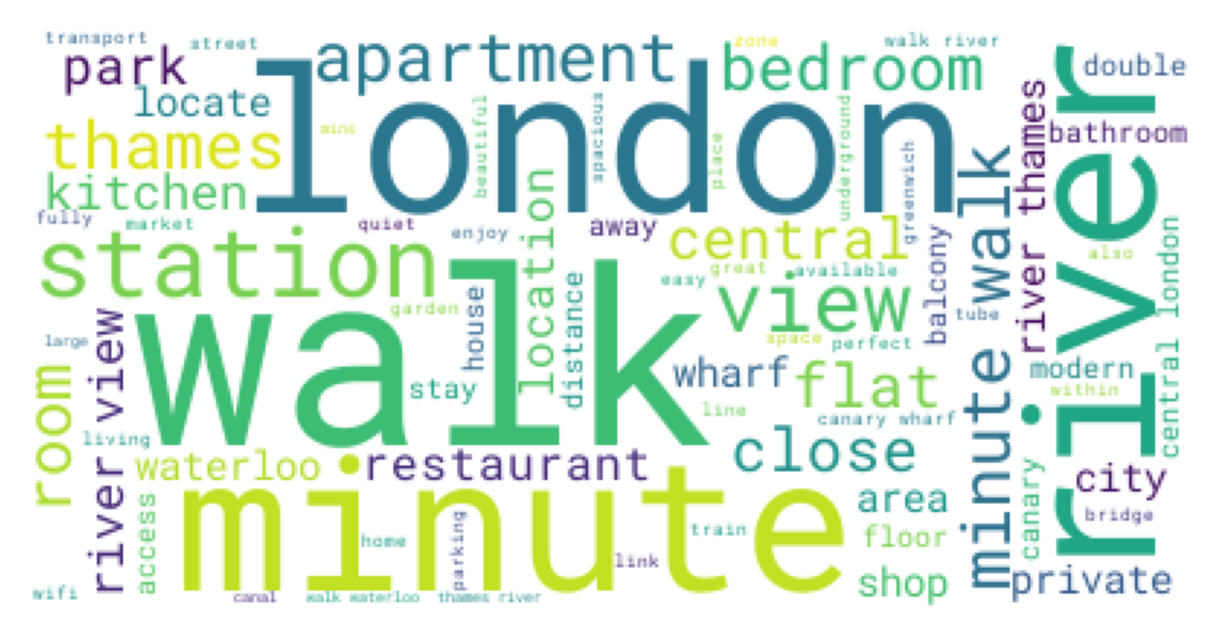

In [46]:
f,ax = plt.subplots(1,1,figsize=(5,5))
plt.gcf().set_dpi(300)
Cloud = WordCloud(
    background_color="white", 
    max_words=75,
    font_path=fp
).generate_from_frequencies(fcvdf.sum())
ax.imshow(Cloud) 
ax.axis("off");
#plt.savefig("Wordcloud 1.png")

### 9.2 For TF/IDF Weighting

> **Difficulty level: Low, but you’ll need to be patient!**

In [47]:
tfidf.sum().sort_values(ascending=False)

walk                       23.946637
minute                     17.656652
london                     17.114220
river                      15.509969
apartment                  14.143728
                             ...    
smart bedroom               0.332017
smart bedroom battersea     0.332017
smart netflixs close        0.332017
terrace overlooking         0.332017
netflixs close              0.332017
Length: 1660, dtype: float64

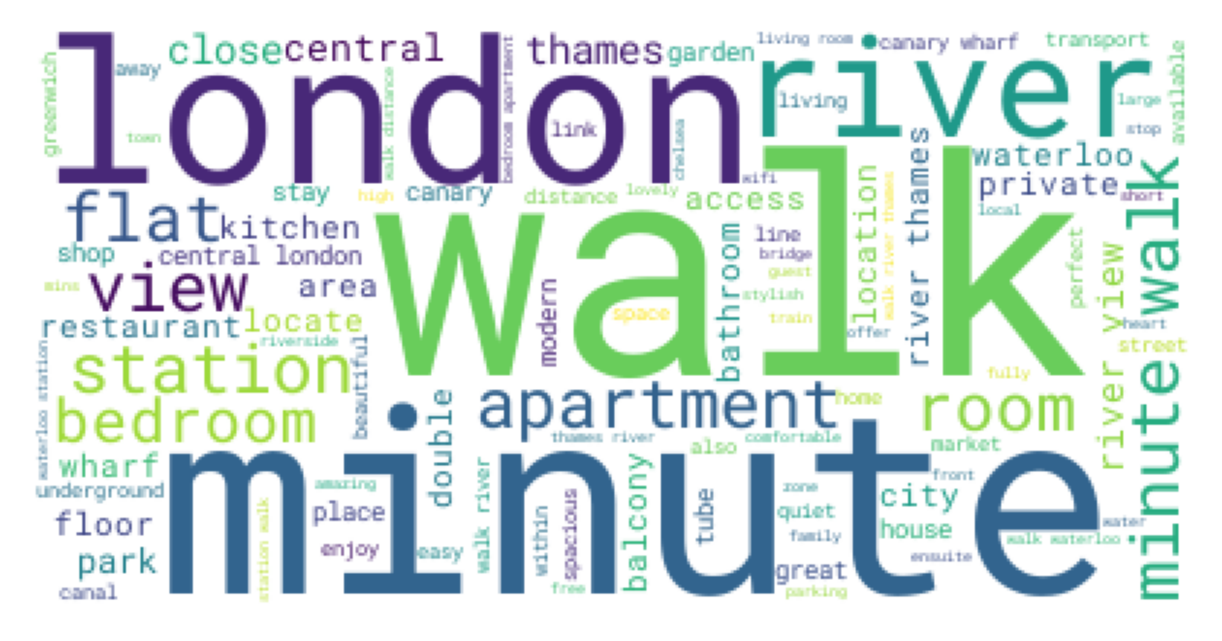

In [48]:
f,ax = plt.subplots(1,1,figsize=(5,5))
plt.gcf().set_dpi(300)
Cloud = WordCloud(
    background_color="white", 
    max_words=100,
    font_path=fp
).generate_from_frequencies(tfidf.sum())
ax.imshow(Cloud) 
ax.axis("off");
#plt.savefig("Wordcloud 2.png")

##### 9.2.0.1 Questions

-   What does the `sum` represent for the count vectoriser?
-   What does the `sum` represent for the TF/IDF vectoriser?

## 10. Latent Dirchlet Allocation

> **Tip**
>
> I would give this a *low* priority. It’s a commonly-used method, but
> on small data sets it really isn’t much use and I’ve found its answers
> to be… unclear… even on large data sets.

Adapted from [this
post](https://stackabuse.com/python-for-nlp-topic-modeling/) on doing
LDA using sklearn. Most other examples use the `gensim` library.

In [49]:
# Notice change to ngram range 
# (try 1,1 and 1,2 for other options)
vectorizer = CountVectorizer(ngram_range=(1,2))

### 10.1 Calculate Topics

In [50]:
vectorizer.fit(corpus) 
tcorpus = vectorizer.transform(corpus) # tcorpus for transformed corpus

LDA = LatentDirichletAllocation(n_components=3, random_state=42) # Might want to experiment with n_components too
LDA.fit(tcorpus)

LatentDirichletAllocation(n_components=3, random_state=42) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. LatentDirichletAllocation ? Documentation for LatentDirichletAllocation i Fitted LatentDirichletAllocation(n_components=3, random_state=42)

In [51]:
first_topic = LDA.components_[0]
top_words = first_topic.argsort()[-25:]

for i in top_words:
    print(vectorizer.get_feature_names_out()[i])

minute walk
easy
stay
locate
access
wharf
waterloo
park
canal
floor
tube
thames
river view
balcony
close
minute
apartment
bedroom
room
river
flat
view
station
london
walk

In [52]:
for i,topic in enumerate(LDA.components_):
    as_markdown(f'Top 10 words for topic #{i}', ', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-25:]]))

### 10.2 Maximum Likelihood Topic

In [53]:
topic_values = LDA.transform(tcorpus)
topic_values.shape

(347, 3)

In [54]:
pd.options.display.max_colwidth=20
srcdf['Topic'] = topic_values.argmax(axis=1)
srcdf.head()

In [55]:
pd.options.display.max_colwidth=75
srcdf[srcdf.Topic==1].description_norm.head(10)

426      enjoy warm cosy modern apartment . river view gorgeous view city . walk...
516      make memory unique familyfriendly place . near nice bridge minute away ...
725      place close mile tube station  brick lane shoreditch  queen mary univer...
4667     beautiful modern onebedroom flat heart london . covent garden literally...
9867     . bath flat tuck safe quiet neighbourhood  walk tube line . hammersmith...
11117    enjoy trendy experience centrallylocated home . historic bedroom apartm...
12188    make memory unique familyfriendly place . near nice bridge minute away ...
12217    newly renovate  totally equipped furnished modern apartment heart londo...
13405    great newly renovate bedroom apartment second room turn office . perfec...
13429    absolutely enormous room available canary wharf  balcony . room comfort...
Name: description_norm, dtype: object

In [56]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)
topic_corpus = vectorizer.fit_transform(srcdf[srcdf.Topic==1].description.values) # tcorpus for transformed corpus

In [57]:
topicdf = pd.DataFrame(data=topic_corpus.toarray(),
                        columns=vectorizer.get_feature_names_out())

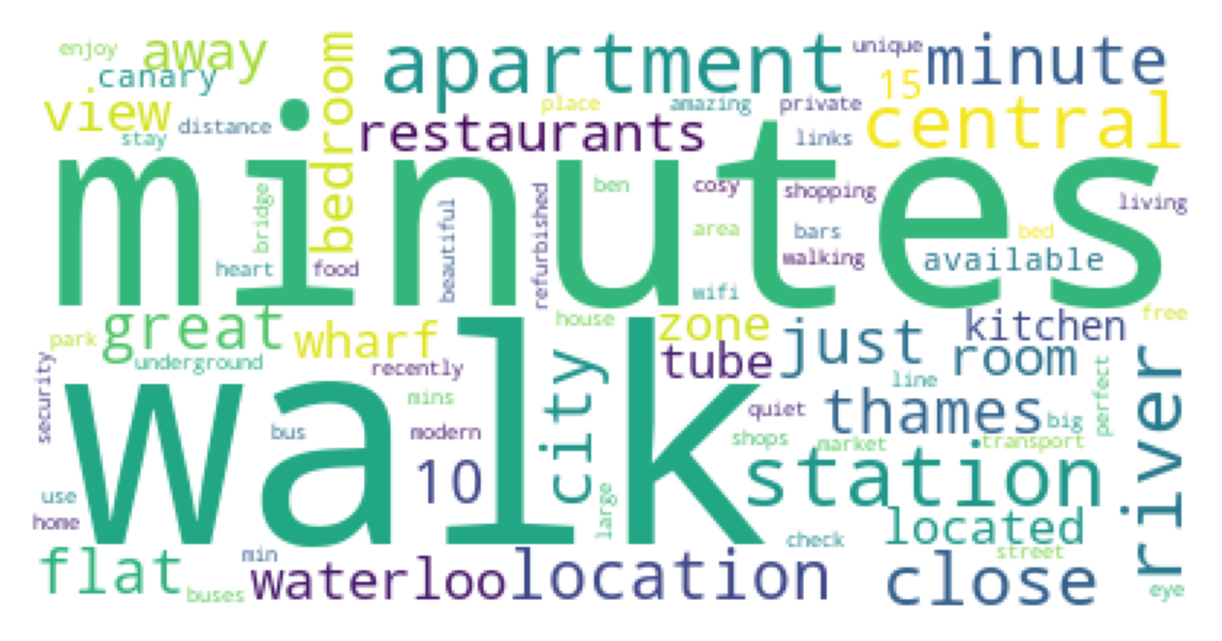

In [58]:
f,ax = plt.subplots(1,1,figsize=(5,5))
plt.gcf().set_dpi(300)
Cloud = WordCloud(
            background_color="white", 
            max_words=75).generate_from_frequencies(topicdf.sum())
ax.imshow(Cloud) 
ax.axis("off");
# plt.savefig('Wordcloud 3.png')

## 11. Word2Vec

> **Tip**
>
> This algorithm works almost like magic. You should play with the
> configuration parameters and see how it changes your results.
> **However**, at this time I’ve not preinstalled `gensim` as it bloated
> the image substantially.

### 11.1 Configure

``` python
from gensim.models.word2vec import Word2Vec
```

``` python
dims = 100
print(f"You've chosen {dims} dimensions.")

window = 4
print(f"You've chosen a window of size {window}.")

min_v_freq  = 0.01 # Don't keep words appearing less than 1% frequency
min_v_count = math.ceil(min_v_freq * srcdf.shape[0])
print(f"With a minimum frequency of {min_v_freq} and {srcdf.shape[0]:,} documents, minimum vocab frequency is {min_v_count:,}.")
```

### 11.2 Train

``` python
%%time 

corpus      = srcdf.description_norm.fillna(' ').values
#corpus_sent = [nltk.sent_tokenize(text) for text in corpus] # <-- with more formal writing this would work well
corpus_sent = [d.replace('.',' ').split(' ') for d in corpus] # <-- deals better with many short sentences though context may end up... weird
model       = Word2Vec(sentences=corpus_sent, vector_size=dims, window=window, epochs=200, 
                 min_count=min_v_count, seed=42, workers=1)

#model.save(f"word2vec-d{dims}-w{window}.model") # <-- You can then Word2Vec.load(...) which is useful with large corpora
```

### 11.3 Explore Similarities

This next bit of code only runs if you have calculated the frequencies
above in the [Frequencies and Ngrams](#frequencies-and-ngrams) section.

``` python
pd.set_option('display.max_colwidth',150)

df = fcounts[1] # <-- copy out only the unigrams as we haven't trained anything else

n     = 14 # number of words
topn  = 7  # number of most similar words

selected_words = df[df['Ngram Size 1'] > 5].reset_index().level_0.sample(n, random_state=42).tolist()

words = []
v1    = []
v2    = []
v3    = []
sims  = []

for w in selected_words:
    try: 
        vector = model.wv[w]  # get numpy vector of a word
        #print(f"Word vector for '{w}' starts: {vector[:5]}...")
    
        sim = model.wv.most_similar(w, topn=topn)
        #print(f"Similar words to '{w}' include: {sim}.")
    
        words.append(w)
        v1.append(vector[0])
        v2.append(vector[1])
        v3.append(vector[2])
        sims.append(", ".join([x[0] for x in sim]))
    except KeyError:
        print(f"Didn't find {w} in model. Can happen with low-frequency terms.")
    
vecs = pd.DataFrame({
    'Term':words,
    'V1':v1, 
    'V2':v2, 
    'V3':v3,
    f'Top {topn} Similar':sims
})

vecs
```

``` python
#print(model.wv.index_to_key) # <-- the full vocabulary that has been trained
```

### 11.4 Apply

We’re going to make *use* of this further next week…

#### 11.4.1 Questions

-   What happens when *dims* is very small (e.g. 25) or very large
    (e.g. 300)?
-   What happens when *window* is very small (e.g. 2) or very large
    (e.g. 8)?

## 12. Processing the Full File

> **Caution**
>
> This code can take *some time* (**\> 5 minutes on a M2 Mac**) to run,
> so **don’t run this** until you’ve understood what we did before!

You will get a warning about `"." looks like a filename, not markup` —
this looks a little scary, but is basically suggesting that we have a
description that consists only of a ‘.’ or that looks like some kind of
URL (which the parser thinks means you’re trying to pass it something to
download).

``` python
%%time 
# This can take up to 8 minutes on a M2 Mac
gdf['description_norm'] = ''
gdf['description_norm'] = gdf.description.apply(normalise_document, remove_digits=True, special_char_removal=True)
```

``` python
gdf.to_parquet(os.path.join('data','geo',f'{fn.replace(".","-with-nlp.")}'))
```

> **Tip**
>
> Saving an intermediate file at this point is useful because you’ve
> done quite a bit of *expensive* computation. You *could*
> restart-and-run-all and then go out for the day, but probably easier
> to just save this output and then, if you need to restart your
> analysis at some point in the future, just remember to deserialise
> amenities back into a list format.

### 12.1 Applications

The above is *still* only the results for the one of the subsets of
apartments *alone*. At this point, you would probably want to think
about how your results might change if you changed any of the following:

1.  Using one of the other data sets that we created, or even the entire
    data set!
2.  Applying the CountVectorizer or TfidfVectorizer *before* selecting
    out any of our ‘sub’ data sets.
3.  Using the visualisation of information to improve our regex
    selection process.
4.  Reducing, increasing, or constraining (i.e. `ngrams=(2,2)`) the size
    of the ngrams while bearing in mind the impact on processing time
    and interpretability.
5.  Filtering by type of listing or host instead of keywords found in
    the description (for instance, what if you applied TF/IDF to the
    entire data set and then selected out ‘Whole Properties’ before
    splitting into those advertised by hosts with only one listing
    vs. those with multiple listings?).
6.  Linking this back to the geography.

Over the next few weeks we’ll also consider alternative means of
visualising the data!

### 12.2 Resources

There is a lot more information out there, including a [whole
book](https://www.nltk.org/book/) and your standard [O’Reilly
text](http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf).

And some more useful links:

-   [Pandas String Contains
    Method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html)
-   [Using Regular Expressions with
    Pandas](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/)
-   [Summarising Chapters from Frankenstein using
    TF/IDF](https://towardsdatascience.com/using-tf-idf-to-form-descriptive-chapter-summaries-via-keyword-extraction-4e6fd857d190)